In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
batchSize= 32
imgSize= 224
rgbChannels= 3
EPOCHS= 100

In [3]:
datasets= tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets/chest_classification/tuberculosis/",
    seed= 128,
    shuffle= True,
    image_size= (imgSize, imgSize),
    batch_size= batchSize
)

Found 2049 files belonging to 2 classes.


In [4]:
clsNames= datasets.class_names
clsNames

['0', '1']

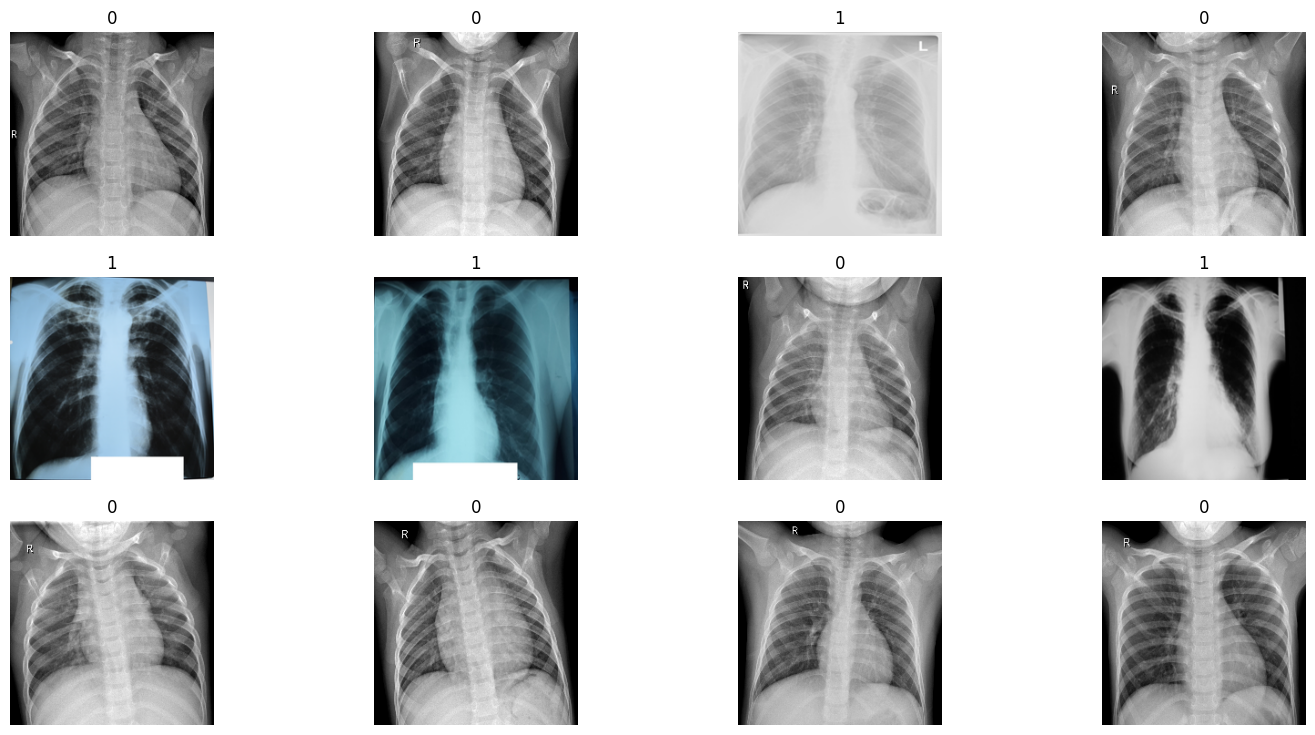

In [5]:
plt.figure(figsize= (18, 9))
for imageBatch, labelBatch in datasets.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(imageBatch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labelBatch[i]])
        plt.axis("off")

In [6]:
def getSplittedDS(ds, trainSplit= 0.8, testSplit= 0.1, valSplit= 0.1, shuffle= True, shuffleSize= 10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    dsSize= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffleSize, seed= 12)
        
    trainSize= int(trainSplit*dsSize)
    valSize= int(valSplit*dsSize)
    
    trainDS= ds.take(trainSize)
    valDS= ds.skip(trainSize).take(valSize)
    testDS= ds.skip(trainSize).skip(valSize)
    
    return trainDS, valDS, testDS

In [7]:
trainDS, valDS, testDS= getSplittedDS(datasets)

In [8]:
len(datasets)

65

In [9]:
trainDS= trainDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
testDS= testDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valDS= valDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [10]:
dataAugmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [11]:
resizeRescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgSize, imgSize),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [12]:
trainDS= trainDS.map(lambda x, y: (dataAugmentation(x, training= True), y)).prefetch(buffer_size= tf.data.AUTOTUNE)

In [13]:
inpShape= (batchSize, imgSize, imgSize, rgbChannels)

model= models.Sequential([
    resizeRescale,
    dataAugmentation,
    layers.Conv2D(80, (2, 2), input_shape= inpShape, activation= 'relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(84, (2, 2), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(96, activation= 'sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(len(clsNames), activation= 'softmax')
])

model.build(input_shape=inpShape)

In [14]:
model.compile(optimizer= 'adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics= ['accuracy'])

In [15]:
early_stop= tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 80)      1040      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 80)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 84)      26964     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 84)       0         
 2D)                                                  

In [17]:
history= model.fit(trainDS, batch_size=batchSize, validation_data= valDS, verbose= 1, epochs= EPOCHS, callbacks=[early_stop])

Epoch 1/100
52/52 [==============================] - 49s 579ms/step - loss: 0.6158 - accuracy: 0.6742 - val_loss: 0.3602 - val_accuracy: 0.8802
Epoch 2/100
52/52 [==============================] - 20s 382ms/step - loss: 0.5147 - accuracy: 0.7789 - val_loss: 0.3403 - val_accuracy: 0.8906
Epoch 3/100
52/52 [==============================] - 20s 384ms/step - loss: 0.3851 - accuracy: 0.8487 - val_loss: 0.3198 - val_accuracy: 0.8333
Epoch 4/100
52/52 [==============================] - 20s 386ms/step - loss: 0.2817 - accuracy: 0.8720 - val_loss: 0.2082 - val_accuracy: 0.9010
Epoch 5/100
52/52 [==============================] - 20s 385ms/step - loss: 0.2345 - accuracy: 0.9057 - val_loss: 0.2008 - val_accuracy: 0.9062
Epoch 6/100
52/52 [==============================] - 20s 387ms/step - loss: 0.2599 - accuracy: 0.8996 - val_loss: 0.4710 - val_accuracy: 0.8750
Epoch 7/100
52/52 [==============================] - 20s 384ms/step - loss: 0.3510 - accuracy: 0.8616 - val_loss: 0.2199 - val_accuracy:

In [21]:
score= model.evaluate(testDS.take(1))

1/1 [==============================] - 0s 410ms/step - loss: 0.0224 - accuracy: 1.0000


In [22]:
acc= history.history['accuracy']
valAccuracy= history.history['val_accuracy']

loss= history.history['loss']
valLoss= history.history['val_loss']

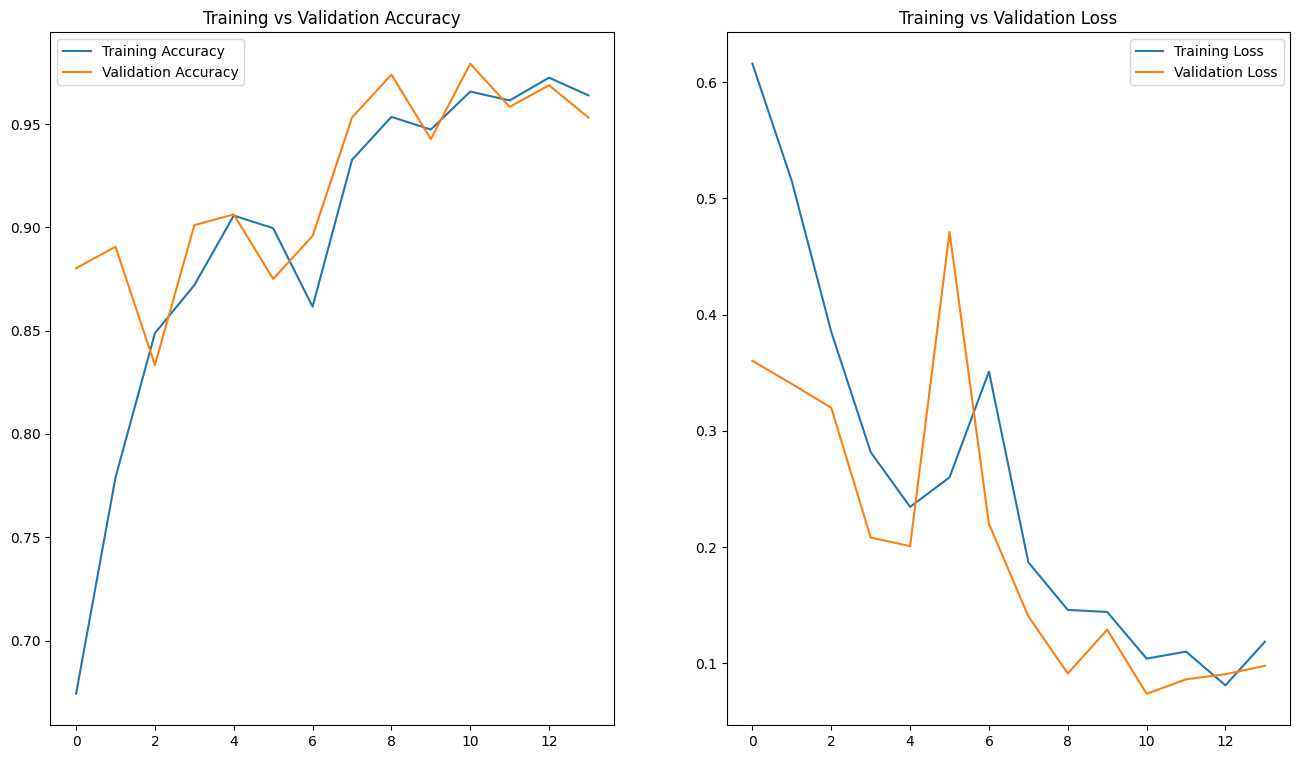

In [24]:
plt.figure(figsize= (16, 9))
plt.subplot(1, 2, 1)
sns.lineplot(x= range(14), y=acc, label= 'Training Accuracy')
plt.title('Training vs Validation Accuracy')
sns.lineplot(x= range(14), y=valAccuracy, label= 'Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x= range(14), y=loss, label= 'Training Loss')
plt.title('Training vs Validation Loss')
sns.lineplot(x= range(14), y=valLoss, label= 'Validation Loss')
plt.legend()
plt.show()

In [25]:
def predFunc(model, img):
    imgArray= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imgArray= tf.expand_dims(imgArray, 0)
    
    predictions= model.predict(imgArray)
    
    predictedClass= clsNames[np.argmax(predictions[0])]
    confidence= round((100*(np.max(predictions[0]))), 2)
    
    return predictedClass, confidence

In [29]:
actual_lbl=[]
pred_lbl=[]

In [31]:
for cycle in range(15):
    print("starting cycle: ", cycle)
    for images, labels in testDS.take(1):
        for i in range(25):
            predictedCls, confidence= predFunc(model, images[i].numpy())
            actualCls= clsNames[labels[i]]

            actual_lbl.append(actualCls)
            pred_lbl.append(predictedCls)
    print("ended cycle: ", cycle)
    print("-----------------")

starting cycle:  0
1/1 [==============================] - 0s 21ms/step
ended cycle:  0
-----------------
starting cycle:  1
1/1 [==============================] - 0s 21ms/step
ended cycle:  1
-----------------
starting cycle:  2
1/1 [==============================] - 0s 27ms/step
ended cycle:  2
-----------------
starting cycle:  3
1/1 [==============================] - 0s 23ms/step
ended cycle:  3
-----------------
starting cycle:  4
1/1 [==============================] - 0s 33ms/step
ended cycle:  4
-----------------
starting cycle:  5
1/1 [==============================] - 0s 22ms/step
ended cycle:  5
-----------------
starting cycle:  6
1/1 [==============================] - 0s 20ms/step
ended cycle:  6
-----------------
starting cycle:  7
1/1 [==============================] - 0s 19ms/step
ended cycle:  7
-----------------
starting cycle:  8
1/1 [==============================] - 0s 22ms/step
ended cycle:  8
-----------------
starting cycle:  9
1/1 [==============================]

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

1/1 [==============================] - 0s 30ms/step


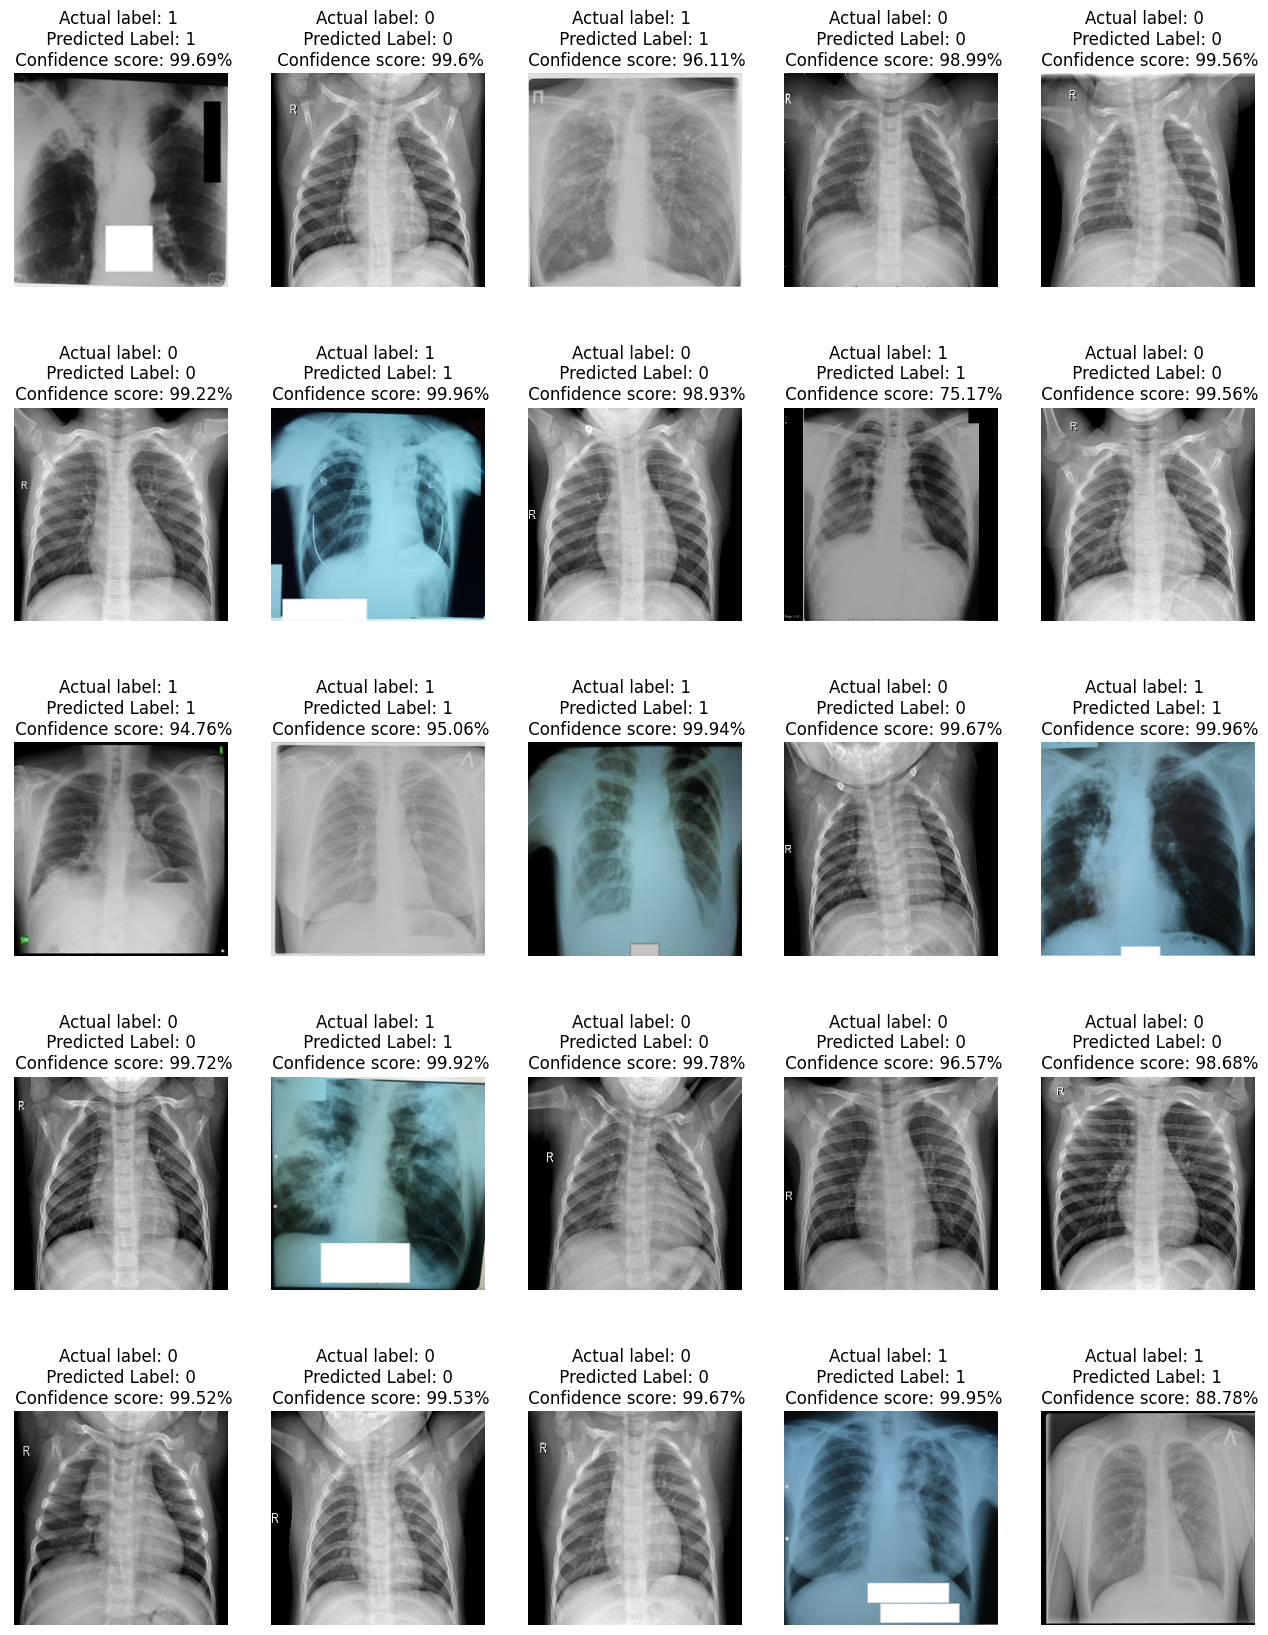

In [37]:
plt.figure(figsize= (16, 21))

for images, labels in testDS.take(1):
    for i in range(25):
        ax= plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predictedCls, confidence= predFunc(model, images[i].numpy())
        actualCls= clsNames[labels[i]]
        
        actual_lbl.append(actualCls)
        pred_lbl.append(predictedCls)
                
        plt.title(f"Actual label: {actualCls} \n Predicted Label: {predictedCls} \n Confidence score: {confidence}%")        
        plt.axis('off')

In [36]:
converter= tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

with open('../exports/tuberculosisV1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpextsxb3h\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpextsxb3h\assets


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [33]:
cm= confusion_matrix(actual_lbl, pred_lbl)
cm

array([[147,   3],
       [  3,  98]], dtype=int64)

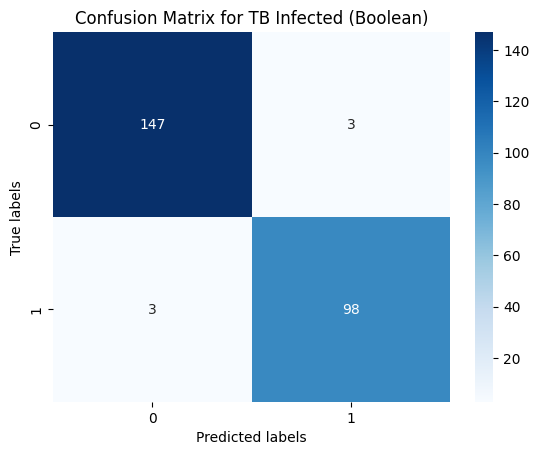

In [35]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix for TB Infected (Boolean)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()